<a href="https://colab.research.google.com/github/AlinaRodina99/diplom/blob/main/GoogleNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision

In [ ]:
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import pandas as pd
import os
from skimage import io
from PIL import Image, ImageFile
import numpy as np
import torch

In [ ]:
torch.manual_seed(17)

In [ ]:
class PaintingsAndPainters(Dataset):
  def __init__(self, csv_file, root_dir, transform):
    self.annotations = pd.read_csv(csv_file, header=None)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    y_label = torch.tensor(self.annotations.iloc[index, 1])
    img_path = self.root_dir + self.annotations.iloc[index, 0]
    image = Image.open(img_path).convert("RGB")
    #transform = transforms.Grayscale()
    #image = transform(image)
    if self.transform:
      image = self.transform(image)
    return (image, y_label)


In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = PaintingsAndPainters(csv_file= 'data_and_labels_init.csv', root_dir = '/content/drive/MyDrive/images_init/', transform = preprocess)

In [ ]:
m = len(dataset)
m

5000

In [ ]:
from torch.utils.data import DataLoader,random_split
import torch

In [ ]:
generator_ = torch.Generator().manual_seed(17)
train_data, val_data = random_split(dataset, [int(m-m*0.1), int(m*0.1)], generator = generator_)

In [ ]:
batch_size=20

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True, num_workers = 1)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle = False, num_workers = 1)

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
from torch import nn

In [ ]:
model = models.googlenet(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Linear(1024, 72).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 71.6MB/s]


In [ ]:
lr = 0.001

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.fc.parameters(), lr=lr, momentum = 0.9)

In [ ]:
def train_epoch(autoencoder, device, dataloader, loss_fn, optimizer, epoch):
    # Set train mode for both the encoder and the decoder
    train_loss = []
    model.train()
    avg_train_loss = 0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, labels in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        labels = labels.to(device)
        # Evaluate loss
        outputs = model(image_batch)
        loss = loss_fn(outputs, labels)
        # Backward pass
        optimizer.zero_grad()
        print('aa')
        loss.backward()
        print('bb')
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        avg_train_loss += loss / len(dataloader)
    global lr
    lr *= 0.8
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=1e-05)
    return avg_train_loss

In [ ]:
val_losses = []
val_accs = []
def test_epoch(autoencoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    model.eval()
    avg_val_loss = 0
    predicted_labels = []
    real_labels = []
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, labels in dataloader:
            # Move tensor to the proper device
            #if torch.cuda.is_available():
               #print('yes')
            image_batch = image_batch.to(device)
            labels = labels.to(device)
            # Decode data
            outputs = model(image_batch)
            # Append the network output and the original image to the lists
            loss = loss_fn(outputs, labels)
            avg_val_loss += loss / len(dataloader)
            predicted_labels.append(outputs.argmax(dim = 1))
            real_labels.append(labels)
    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    val_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)
    return avg_val_loss, val_acc

In [ ]:
checkpoint = torch.load("/content/drive/MyDrive/model.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optim.load_state_dict(checkpoint['optimizer_state_dict'])
lr = checkpoint['lr']
lr

RuntimeError: ignored

In [ ]:
num_epochs = 100
counter = 0
for epoch in range(num_epochs):
   train_loss =train_epoch(model,device, train_loader,loss_fn, optim, epoch)
   val_loss_acc = test_epoch(model, device,valid_loader,loss_fn)
   val_loss = val_loss_acc[0]
   val_acc = val_loss_acc[1]
   
   torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': val_loss,
            'counter': counter,
            'lr' : lr
            }, "/content/drive/MyDrive/model.pt")
   #if epoch > 0:
    
     #checkpoint = torch.load("/content/drive/MyDrive/model.pt")
     #val_loss_prev = checkpoint['loss']
     #if val_loss_prev - val_loss <= 0:
       #counter += 1
       #if counter > 7:
        # break
   print('\n EPOCH {}/{} \t train loss {} \t val loss {} \t val acc {}'.format(epoch + 1, num_epochs,train_loss,val_loss, val_acc))

aa
bb
	 partial train loss (single batch): 4.313716
aa
bb
	 partial train loss (single batch): 4.272635
aa
bb
	 partial train loss (single batch): 4.250210
aa
bb
	 partial train loss (single batch): 4.326360
aa
bb
	 partial train loss (single batch): 4.355966
aa
bb
	 partial train loss (single batch): 4.350648
aa
bb
	 partial train loss (single batch): 4.329114
aa
bb
	 partial train loss (single batch): 4.284250
aa
bb
	 partial train loss (single batch): 4.270373
aa
bb
	 partial train loss (single batch): 4.279221
aa
bb
	 partial train loss (single batch): 4.128461
aa
bb
	 partial train loss (single batch): 4.080291
aa
bb
	 partial train loss (single batch): 4.296702
aa
bb
	 partial train loss (single batch): 4.200619
aa
bb
	 partial train loss (single batch): 4.191500
aa
bb
	 partial train loss (single batch): 4.172758
aa
bb
	 partial train loss (single batch): 4.258401
aa
bb
	 partial train loss (single batch): 4.049560
aa
bb
	 partial train loss (single batch): 4.178111
aa
bb
	 part

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


aa
bb
	 partial train loss (single batch): 3.744439
aa
bb
	 partial train loss (single batch): 3.887403
aa
bb
	 partial train loss (single batch): 4.089662
aa
bb
	 partial train loss (single batch): 3.941170
aa
bb
	 partial train loss (single batch): 3.747885
aa
bb
	 partial train loss (single batch): 3.547716
aa
bb
	 partial train loss (single batch): 3.490813
aa
bb
	 partial train loss (single batch): 3.766975
aa
bb
	 partial train loss (single batch): 3.948521
aa
bb
	 partial train loss (single batch): 3.371674
aa
bb
	 partial train loss (single batch): 4.012302
aa
bb
	 partial train loss (single batch): 3.704456
aa
bb
	 partial train loss (single batch): 3.716913
aa
bb
	 partial train loss (single batch): 3.809751
aa
bb
	 partial train loss (single batch): 3.970259
aa
bb
	 partial train loss (single batch): 4.142098
aa
bb
	 partial train loss (single batch): 3.580757
aa
bb
	 partial train loss (single batch): 4.063479
aa
bb
	 partial train loss (single batch): 3.948787
aa
bb
	 part

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


aa
bb
	 partial train loss (single batch): 3.599028
aa
bb
	 partial train loss (single batch): 3.118765
aa
bb
	 partial train loss (single batch): 3.502812
aa
bb
	 partial train loss (single batch): 3.459288
aa
bb
	 partial train loss (single batch): 3.437572
aa
bb
	 partial train loss (single batch): 3.479688
aa
bb
	 partial train loss (single batch): 3.211889
aa
bb
	 partial train loss (single batch): 3.486985
aa
bb
	 partial train loss (single batch): 3.493720
aa
bb
	 partial train loss (single batch): 3.729129
aa
bb
	 partial train loss (single batch): 3.731515
aa
bb
	 partial train loss (single batch): 3.620709
aa
bb
	 partial train loss (single batch): 3.645364
aa
bb
	 partial train loss (single batch): 3.790528
aa
bb
	 partial train loss (single batch): 3.420884
aa
bb
	 partial train loss (single batch): 3.425155
aa
bb
	 partial train loss (single batch): 3.548825
aa
bb
	 partial train loss (single batch): 3.606361
aa
bb
	 partial train loss (single batch): 3.779369
aa
bb
	 part

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


aa
bb
	 partial train loss (single batch): 3.716473
aa
bb
	 partial train loss (single batch): 3.288309
aa
bb
	 partial train loss (single batch): 3.411630
aa
bb
	 partial train loss (single batch): 3.253552
aa
bb
	 partial train loss (single batch): 3.488478
aa
bb
	 partial train loss (single batch): 3.191977
aa
bb
	 partial train loss (single batch): 3.072548
aa
bb
	 partial train loss (single batch): 2.967427
aa
bb
	 partial train loss (single batch): 3.224407
aa
bb
	 partial train loss (single batch): 3.209483
aa
bb
	 partial train loss (single batch): 3.282555
aa
bb
	 partial train loss (single batch): 3.739558
aa
bb
	 partial train loss (single batch): 3.190890
aa
bb
	 partial train loss (single batch): 3.255730
aa
bb
	 partial train loss (single batch): 3.131068
aa
bb
	 partial train loss (single batch): 3.189001
aa
bb
	 partial train loss (single batch): 3.196130
aa
bb
	 partial train loss (single batch): 2.830422
aa
bb
	 partial train loss (single batch): 3.091473
aa
bb
	 part

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


aa
bb
	 partial train loss (single batch): 3.158943
aa
bb
	 partial train loss (single batch): 3.420146
aa
bb
	 partial train loss (single batch): 3.195659
aa
bb
	 partial train loss (single batch): 3.305874
aa
bb
	 partial train loss (single batch): 3.503248
aa
bb
	 partial train loss (single batch): 2.966659
aa
bb
	 partial train loss (single batch): 3.242305
aa
bb
	 partial train loss (single batch): 3.215574
aa
bb
	 partial train loss (single batch): 3.129031
aa
bb
	 partial train loss (single batch): 2.674485
aa
bb
	 partial train loss (single batch): 2.386399
aa
bb
	 partial train loss (single batch): 2.700500
aa
bb
	 partial train loss (single batch): 3.262127
aa
bb
	 partial train loss (single batch): 3.092437
aa
bb
	 partial train loss (single batch): 3.350302
aa
bb
	 partial train loss (single batch): 3.104169
aa
bb
	 partial train loss (single batch): 2.786581
aa
bb
	 partial train loss (single batch): 3.005366
aa
bb
	 partial train loss (single batch): 2.986810
aa
bb
	 part

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


aa
bb
	 partial train loss (single batch): 3.085926
aa
bb
	 partial train loss (single batch): 3.228862
aa
bb
	 partial train loss (single batch): 2.458373
aa
bb
	 partial train loss (single batch): 3.138189
aa
bb
	 partial train loss (single batch): 3.086195
aa
bb
	 partial train loss (single batch): 3.527035
aa
bb
	 partial train loss (single batch): 3.021692
aa
bb
	 partial train loss (single batch): 2.624007
aa
bb
	 partial train loss (single batch): 2.648482
aa
bb
	 partial train loss (single batch): 2.766777
aa
bb
	 partial train loss (single batch): 2.707930
aa
bb
	 partial train loss (single batch): 2.450270
aa
bb
	 partial train loss (single batch): 2.650167
aa
bb
	 partial train loss (single batch): 3.055598
aa
bb
	 partial train loss (single batch): 3.358829
aa
bb
	 partial train loss (single batch): 3.187192
aa
bb
	 partial train loss (single batch): 2.596756
aa
bb
	 partial train loss (single batch): 2.513694
aa
bb
	 partial train loss (single batch): 2.788290
aa
bb
	 part

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


aa
bb
	 partial train loss (single batch): 2.955021
aa
bb
	 partial train loss (single batch): 3.358535
aa
bb
	 partial train loss (single batch): 2.798845
aa
bb
	 partial train loss (single batch): 3.045915
aa
bb
	 partial train loss (single batch): 2.841191
aa
bb
	 partial train loss (single batch): 2.602064
aa
bb
	 partial train loss (single batch): 2.771674
aa
bb
	 partial train loss (single batch): 3.065697
aa
bb
	 partial train loss (single batch): 2.661262
aa
bb
	 partial train loss (single batch): 2.927330
aa
bb
	 partial train loss (single batch): 3.374217
aa
bb
	 partial train loss (single batch): 2.505198
aa
bb
	 partial train loss (single batch): 3.098977
aa
bb
	 partial train loss (single batch): 2.847856
aa
bb
	 partial train loss (single batch): 3.048183
aa
bb
	 partial train loss (single batch): 2.702164
aa
bb
	 partial train loss (single batch): 3.104431
aa
bb
	 partial train loss (single batch): 2.899670
aa
bb
	 partial train loss (single batch): 2.956758
aa
bb
	 part

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


aa
bb
	 partial train loss (single batch): 2.757669
aa
bb
	 partial train loss (single batch): 2.875345
aa
bb
	 partial train loss (single batch): 2.458761
aa
bb
	 partial train loss (single batch): 2.572888
aa
bb
	 partial train loss (single batch): 2.530607
aa
bb
	 partial train loss (single batch): 2.899588
aa
bb
	 partial train loss (single batch): 2.614560
aa
bb
	 partial train loss (single batch): 3.066832
aa
bb
	 partial train loss (single batch): 2.851633
aa
bb
	 partial train loss (single batch): 2.988857
aa
bb
	 partial train loss (single batch): 2.839845
aa
bb
	 partial train loss (single batch): 2.285782
aa
bb
	 partial train loss (single batch): 3.308178
aa
bb
	 partial train loss (single batch): 2.565524
aa
bb
	 partial train loss (single batch): 2.639019
aa
bb
	 partial train loss (single batch): 2.445578
aa
bb
	 partial train loss (single batch): 2.592430
aa
bb
	 partial train loss (single batch): 2.951306
aa
bb
	 partial train loss (single batch): 2.883528
aa
bb
	 part

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


aa
bb
	 partial train loss (single batch): 2.669815
aa
bb
	 partial train loss (single batch): 2.366857
aa
bb
	 partial train loss (single batch): 2.405025
aa
bb
	 partial train loss (single batch): 2.441071
aa
bb
	 partial train loss (single batch): 2.772112
aa
bb
	 partial train loss (single batch): 1.692607
aa
bb
	 partial train loss (single batch): 2.877830

 EPOCH 8/100 	 train loss 2.644055128097534 	 val loss 2.6697206497192383 	 val acc 0.40799999237060547
aa
bb
	 partial train loss (single batch): 2.678551
aa
bb
	 partial train loss (single batch): 2.803383
aa
bb
	 partial train loss (single batch): 2.686071
aa
bb
	 partial train loss (single batch): 2.428892
aa
bb
	 partial train loss (single batch): 2.271031
aa
bb
	 partial train loss (single batch): 2.874514
aa
bb
	 partial train loss (single batch): 2.216933
aa
bb
	 partial train loss (single batch): 2.629177
aa
bb
	 partial train loss (single batch): 2.335543
aa
bb
	 partial train loss (single batch): 2.528674
aa
bb
	 par

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


aa
bb
	 partial train loss (single batch): 2.628085
aa
bb
	 partial train loss (single batch): 3.075749
aa
bb
	 partial train loss (single batch): 2.784853
aa
bb
	 partial train loss (single batch): 3.189584
aa
bb
	 partial train loss (single batch): 2.833094
aa
bb
	 partial train loss (single batch): 2.894096
aa
bb
	 partial train loss (single batch): 2.345321
aa
bb
	 partial train loss (single batch): 2.198177
aa
bb
	 partial train loss (single batch): 2.433191
aa
bb
	 partial train loss (single batch): 2.858661
aa
bb
	 partial train loss (single batch): 2.668849
aa
bb
	 partial train loss (single batch): 3.028650
aa
bb
	 partial train loss (single batch): 3.022084
aa
bb
	 partial train loss (single batch): 3.094719
aa
bb
	 partial train loss (single batch): 2.085471
aa
bb
	 partial train loss (single batch): 2.631635
aa
bb
	 partial train loss (single batch): 2.844118
aa
bb
	 partial train loss (single batch): 2.366139
aa
bb
	 partial train loss (single batch): 2.948574
aa
bb
	 part

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

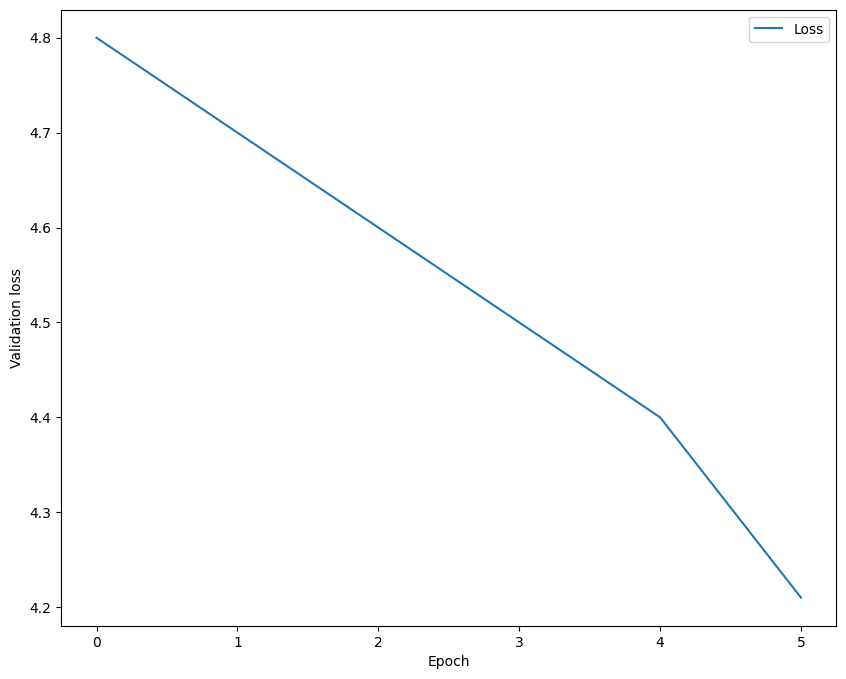

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(val_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

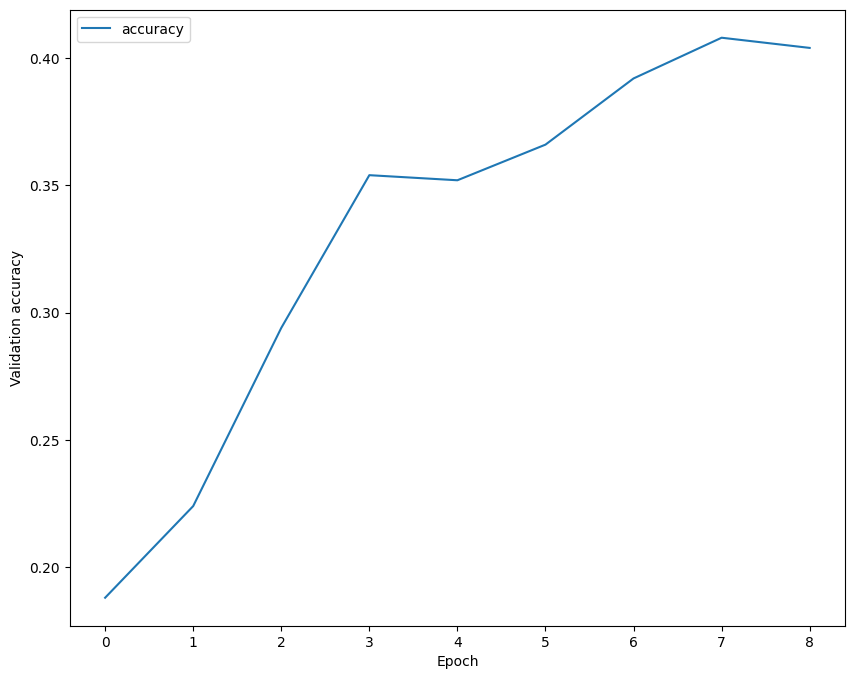

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(val_accs, label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [ ]:
val_losses = [4.8, 4.7, 4.6, 4.5, 4.4, 4.21]
val_accs = [0.16, 0.17, 0.1721, 0.1724]

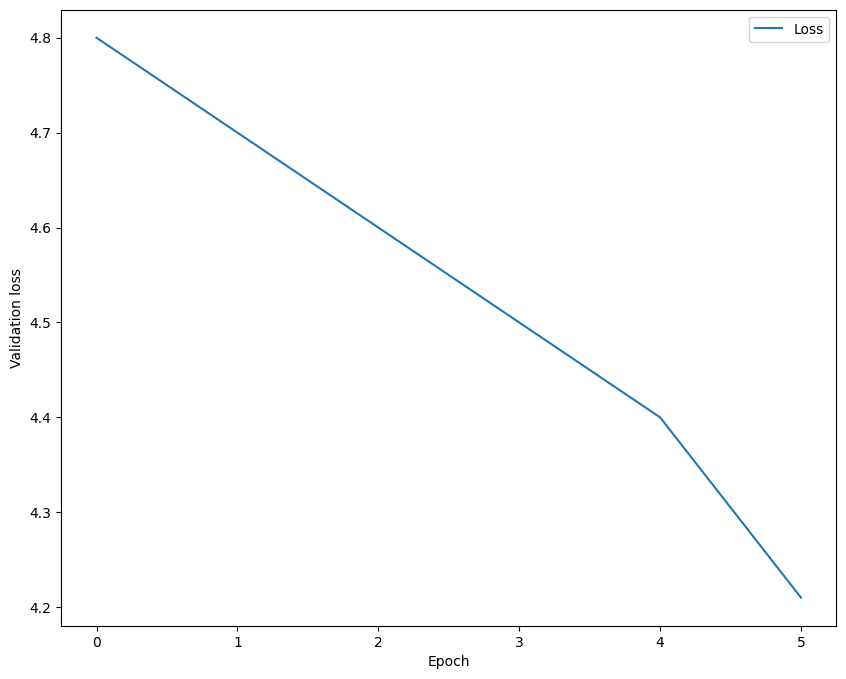

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(val_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

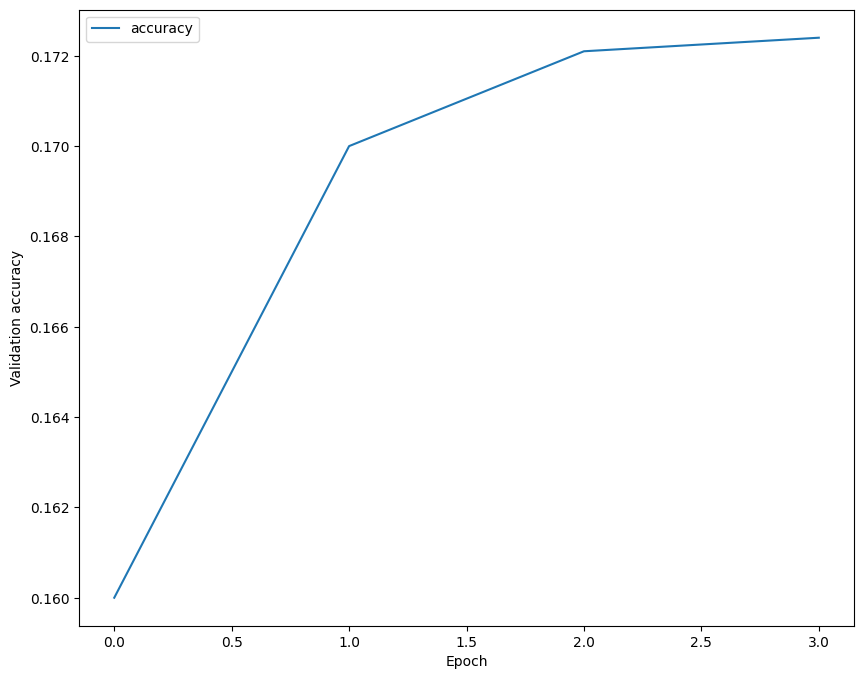

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(val_accs, label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()